In [7]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from wordcloud import WordCloud


In [3]:
df = pd.read_csv("input/twitter_sentiment_data.csv")
df.drop(columns=["tweetid"])
df = df.drop(df[df.sentiment == 2].index)

cv_all, test = np.split(df.sample(frac=1, random_state=0), [int(.8*len(df))])
cv_all_polar = cv_all.drop(cv_all[cv_all.sentiment == 0].index)
test_polar = test.drop(test[test.sentiment == 0].index)
print(cv_all.shape)
print(test.shape)

(27733, 3)
(6934, 3)


/opt/anaconda3/envs/tf/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [4]:
if not os.path.isfile(f"model/config.json"):
    new_model = SentenceTransformer("all-MiniLM-L12-v2")
    new_model.save("model/")
transformer = SentenceTransformer.load("model/")

In [5]:
def preprocess_dataframe(dataframe):
    messages = dataframe["message"].values
    processed = []
    for message in messages:
        remove_retweets = re.sub(r"RT @\w+:", "", message)
        remove_ats = re.sub(r"@\w+:", "", remove_retweets)
        remove_hashtags = re.sub(r"#", "", remove_ats)
        processed.append(remove_hashtags)
    encoded = transformer.encode(processed)
    dataframe["encoded"] = encoded.tolist()

In [6]:
preprocess_dataframe(cv_all)
preprocess_dataframe(cv_all_polar)

In [8]:
model = svm.SVC(kernel="poly")
# scores = cross_val_score(model, cv_all["encoded"].tolist(), cv_all["sentiment"], cv=5)
# print(scores)

In [10]:
def scores_f1(estimator, X, y):
    y_pred = estimator.predict(X)
    return f1_score(y, y_pred, average='micro')

def scores_accuracy(estimator, X, y):
    y_pred = estimator.predict(X)
    return accuracy_score(y, y_pred)

In [11]:
scores_dict_f1 = cross_val_score(model, cv_all["encoded"].tolist(), cv_all["sentiment"], scoring=scores_f1, cv=5)
print(f"f1 scores with neutral: {scores_dict_f1}")

In [ ]:
scores_dict_accuracy = cross_val_score(model, cv_all["encoded"].tolist(), cv_all["sentiment"], scoring=scores_accuracy, cv=5)
print(f"accuracy scores with neutral: {scores_dict_accuracy}")

accuracy scores with neutral: [0.78799351 0.79033712 0.78528935 0.79102056 0.79084025]


In [1]:
#without neutral
model_polar = svm.SVC(kernel="poly")

NameError: name 'svm' is not defined

In [ ]:
scores_dict_f1_polar = cross_val_score(model_polar, cv_all_polar["encoded"].tolist(), cv_all_polar["sentiment"], scoring=scores_f1, cv=5)
print(f"f1 scores without neutral: {scores_dict_f1_polar}")

In [ ]:
scores_dict_accuracy_polar = cross_val_score(model_polar, cv_all_polar["encoded"].tolist(), cv_all_polar["sentiment"], scoring=scores_accuracy, cv=5)
print(f"accuracy scores without neutral: {scores_dict_accuracy_polar}")

In [9]:
# examples of failure
model.fit(cv_all["encoded"].tolist(), cv_all["sentiment"])



SVC(kernel='poly')

In [10]:
example_predictions = model.predict(cv_all["encoded"].tolist()[:200])
for i in range(200):
    if example_predictions[i] != cv_all['sentiment'].tolist()[i]:
        print(f"\n prediction:{example_predictions[i]} true:{cv_all['sentiment'].tolist()[i]} \n message:{cv_all['message'].tolist()[i]}")


 prediction:1 true:-1 
 message:RT @TwitchyTeam: New York Times 'slammed' with cancellations as punishment for climate change heresy https://t.co/uritRij1d6

 prediction:1 true:0 
 message:We did it, America. We beat global warming. https://t.co/BbZqC4J6zF

 prediction:1 true:-1 
 message:RT @Cernovich: $q$Global warming is real.$q$ - Science https://t.co/BqV5SCZMfq

 prediction:0 true:1 
 message:RT @TheMisterFavor: #NationalGeographicÃ¢â‚¬â„¢s climate change documentary with #LeonardoDiCaprio is now on #YouTube! https://t.co/yEA6kinX2AÃ¢â‚¬Â¦

 prediction:1 true:-1 
 message:RT @matthaggis666: Today on #abcforkids we have IPA's Georgina Downer explaining why climate change isn't real, and how voluntary voting isÃ¢â‚¬Â¦

 prediction:0 true:-1 
 message:Rebel Media: So who are the scientists who$q$ll be advising Trudeau, premiers on climate change?… https://t.co/Eioh8m817F #tcot #tlot #tgdn

 prediction:1 true:0 
 message:When Mother Earth sees you tweet that climate change isnâ€™t re

In [11]:

#reddit data (copied from Thierry's section)
reddit_df = pd.read_csv('input/reddit_opinion_climate_change.csv',index_col=['comment_id'], parse_dates=['created_time', 'post_created_time'])
filtered_reddit_df = reddit_df.loc[reddit_df['subreddit'].isin(['climatechange', 'climate', 'climateskeptics'])]



In [12]:
def preprocess_dataframe_reddit(dataframe):
    messages = dataframe["self_text"].values
    processed = []
    for message in messages:
        as_str = str(message) if message is not None else ''
        remove_retweets = re.sub(r"RT @\w+:", "", as_str)
        remove_ats = re.sub(r"@\w+:", "", remove_retweets)
        remove_hashtags = re.sub(r"#", "", remove_ats)
        processed.append(remove_hashtags)
    encoded = transformer.encode(processed)
    dataframe["encoded"] = encoded.tolist()
    
    dataframe['year'] = pd.DatetimeIndex(dataframe['post_created_time']).year

In [13]:
sampled_reddit_df = filtered_reddit_df.sample(n=10000, random_state=0)
preprocess_dataframe_reddit(sampled_reddit_df)

In [14]:
example_predictions = model.predict(sampled_reddit_df["encoded"].tolist())

In [15]:
sampled_reddit_df["sentiment"] = example_predictions


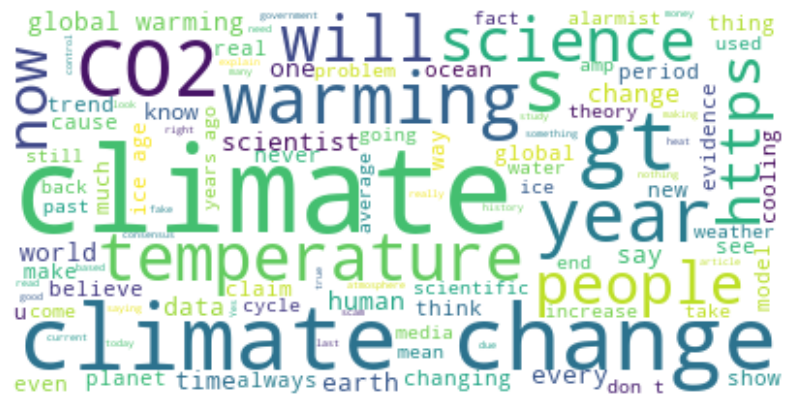

In [17]:
# Filter DataFrame to only include rows with negative sentiment
negative_posts = sampled_reddit_df[sampled_reddit_df['sentiment'] == -1]

# Join all messages into a single string
text = ' '.join(post for post in negative_posts['self_text'])

# Create and generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(text)

# Display the generated image
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

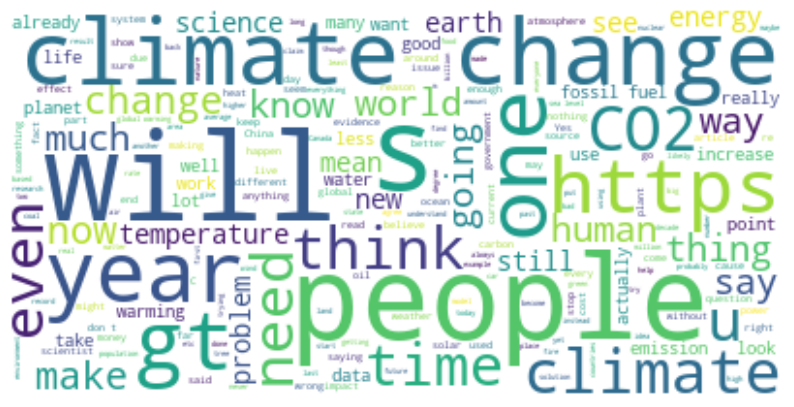

In [18]:
# Filter DataFrame to only include rows with negative sentiment
negative_posts = sampled_reddit_df[sampled_reddit_df['sentiment'] == 1]

# Join all messages into a single string
text = ' '.join(post for post in negative_posts['self_text'])

# Create and generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(text)

# Display the generated image
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

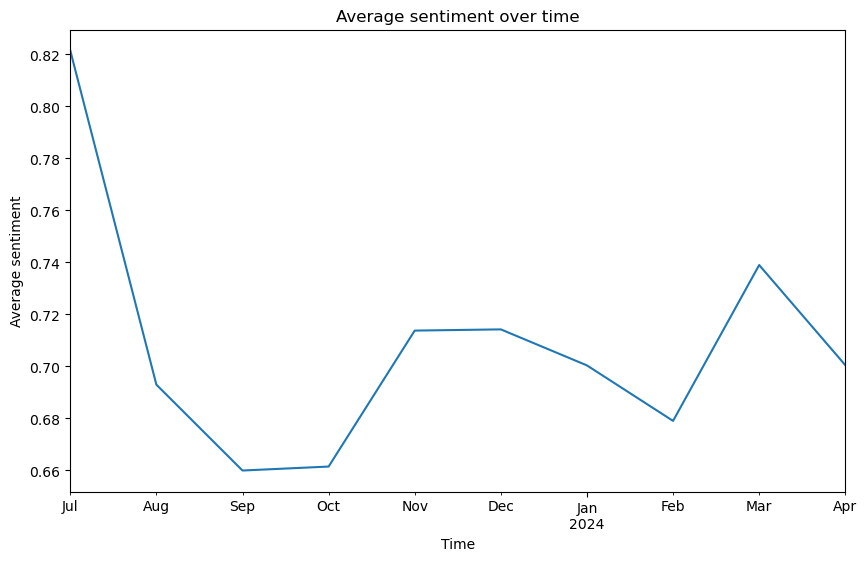

In [19]:
sampled_reddit_df['year-month'] = sampled_reddit_df['post_created_time'].dt.to_period('M')
# Group by month and year and calculate mean sentiment
grouped = sampled_reddit_df.groupby('year-month')['sentiment'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
grouped.plot(kind='line')
plt.title('Average sentiment over time')
plt.xlabel('Time')
plt.ylabel('Average sentiment')
plt.show()



<Figure size 1000x600 with 0 Axes>

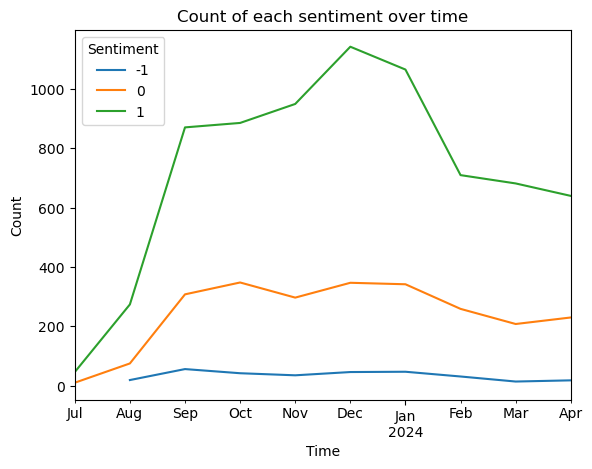

In [20]:
# Group by month and sentiment and count the occurrences
grouped = sampled_reddit_df.groupby('year-month')['sentiment'].value_counts().unstack()

# Plot the results
plt.figure(figsize=(10, 6))
grouped.plot(kind='line')
plt.title('Count of each sentiment over time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(title='Sentiment', loc='upper left')
plt.show()

In [21]:
all_reddit_df = reddit_df
preprocess_dataframe_reddit(all_reddit_df)



In [24]:
all_predictions = model.predict(all_reddit_df["encoded"].tolist())
all_reddit_df["sentiment"] = all_predictions


In [25]:
all_reddit_df.to_csv('input/reddit_data_with_sentiment.csv')

<Figure size 1000x600 with 0 Axes>

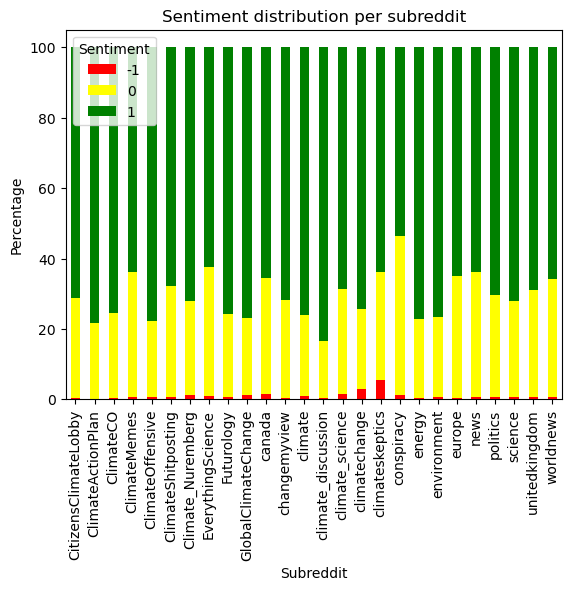

In [26]:
# Calculate the percentage of each sentiment for each subreddit
sentiment_counts = all_reddit_df.groupby('subreddit')['sentiment'].value_counts(normalize=True).mul(100).unstack()

# Plot the results
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', stacked=True, color=['red', 'yellow', 'green'])
plt.title('Sentiment distribution per subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Percentage')
plt.legend(title='Sentiment', loc='upper left')
plt.show()

ModuleNotFoundError: No module named 'seaborn'